# Detecção de Anomalias em Óbitos usando Isolation Forest
Este notebook tem como objetivo identificar possíveis fraudes em registros de óbitos utilizando técnicas de Machine Learning não supervisionado. O algoritmo escolhido foi o **Isolation Forest**, adequado para detecção de outliers em dados não rotulados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [2]:
# Carregar os dados
df = pd.read_csv('obitos_normalizados.csv')
df = df[(df['PCT_IDOSOS'] != 0) & (df['PCT_IDOSOS'].notna())].copy()

## Análise Exploratória de Dados (EDA)

In [3]:
# Estatísticas descritivas
df.describe(include='all')

,CD_DIST,NM_DIST,M >= 60 ANOS,F >= 60 ANOS,OBITOS TOTAIS (M+F),PCT_DOMICILIOS_COM_OBITO,2019 (M+F >= 60 anos),2020 (M+F >= 60 anos),2021 (M+F >= 60 anos),2022 (M+F >= 60 anos),AREA_KM2,POP_TOTAL,DENSIDADE_DEMOGRAFICA,PCT_IDOSOS,OBITOS_PER_CAPITA
count,9.816000e+03,9816,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9.816000e+03,9816.000000,9816.000000,9816.000000
unique,NaN,8551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Santo Antônio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.246250e+08,NaN,91.853301,85.966178,368.988896,5.705073,17.719234,22.025774,39.337816,14.209963,813.831262,2.061837e+04,247.798602,0.905088,0.018419
std,9.285017e+07,NaN,498.569664,559.065506,1976.867300,1.486794,112.592674,161.410231,247.801810,78.592770,3663.649825,1.008044e+05,1402.790368,0.460995,0.005968
min,1.100015e+08,NaN,0.000000,0.000000,3.000000,0.630666,0.000000,0.000000,0.000000,0.000000,0.166544,1.140000e+02,0.061794,0.021817,0.001701
25%,2.601102e+08,NaN,9.000000,6.000000,35.000000,4.777757,0.000000,0.000000,3.000000,0.000000,95.531879,2.032000e+03,9.290261,0.586630,0.014614
50%,3.145889e+08,NaN,23.000000,18.000000,87.000000,5.655011,3.000000,3.000000,8.000000,3.000000,206.027000,4.835000e+03,21.492961,0.854598,0.018211
75%,4.114733e+08,NaN,62.000000,50.000000,243.000000,6.520345,12.000000,13.000000,24.000000,10.000000,486.203025,1.365600e+04,51.241540,1.148499,0.021780


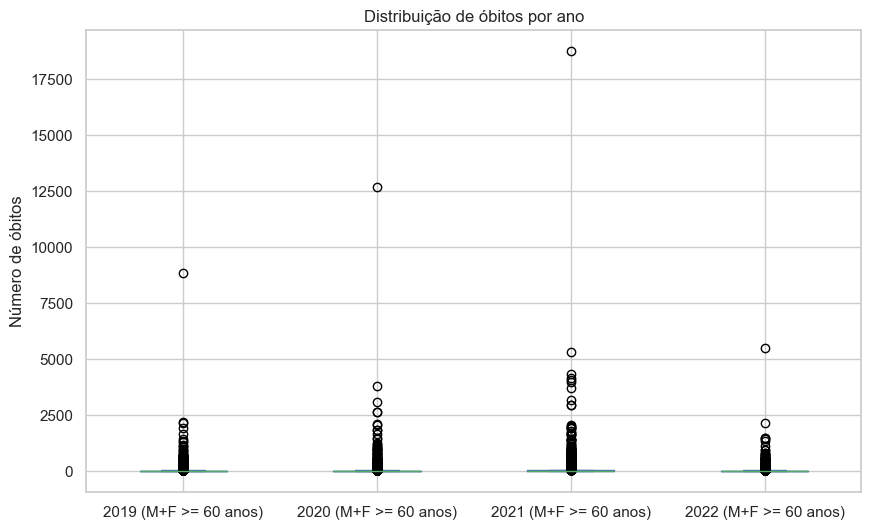

In [4]:
# Distribuição de óbitos por ano
obitos_cols = ['2019 (M+F >= 60 anos)', '2020 (M+F >= 60 anos)', '2021 (M+F >= 60 anos)', '2022 (M+F >= 60 anos)']
df[obitos_cols].plot(kind='box', figsize=(10,6), title='Distribuição de óbitos por ano')
plt.ylabel('Número de óbitos')
plt.show()

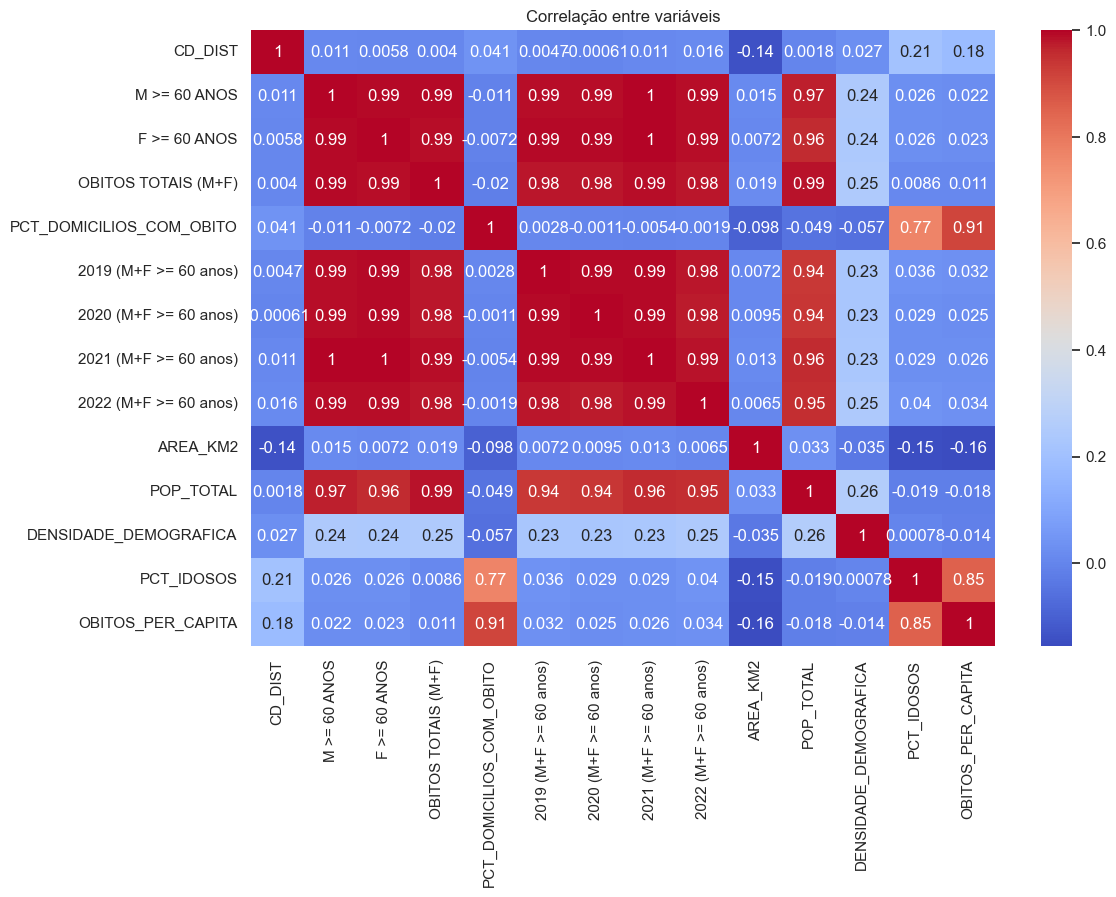

In [6]:
# Heatmap de correlação (somente com variáveis numéricas)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()

## Pré-processamento

In [7]:
features = ['CD_DIST', '2019 (M+F >= 60 anos)', '2020 (M+F >= 60 anos)', 
           '2021 (M+F >= 60 anos)', '2022 (M+F >= 60 anos)',
           'DENSIDADE_DEMOGRAFICA', 'PCT_IDOSOS', 'OBITOS_PER_CAPITA']

# Seleção e transformação das variáveis
X = df[features].copy()
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Por que Isolation Forest?
O Isolation Forest é um algoritmo eficiente para detectar outliers em conjuntos de dados não rotulados. Ele funciona isolando observações em árvores de decisão; anomalias tendem a ser isoladas em menos divisões. Por isso, é apropriado para detectar registros suspeitos de óbitos com base em padrões incomuns nos dados.

## Treinamento com Otimização de Hiperparâmetros

In [8]:
param_grid = {
    'n_estimators': [100, 150],
    'contamination': [0.01, 0.05, 0.1]
}
melhor_score = float('inf')
melhor_modelo = None
melhor_param = None

for params in ParameterGrid(param_grid):
    modelo = IsolationForest(**params, random_state=42)
    modelo.fit(X_scaled)
    scores = modelo.decision_function(X_scaled)
    score_medio = np.mean(scores)
    if score_medio < melhor_score:
        melhor_score = score_medio
        melhor_modelo = modelo
        melhor_param = params

print('Melhores hiperparâmetros:', melhor_param)

Melhores hiperparâmetros: {'contamination': 0.1, 'n_estimators': 150}


## Aplicação do Modelo e Análise dos Resultados

In [9]:
df['ANOMALY_SCORE'] = melhor_modelo.decision_function(X_scaled)
df['ANOMALIA'] = melhor_modelo.predict(X_scaled)
df['ANOMALIA'] = df['ANOMALIA'].map({1: 0, -1: 1})  # 1 para anomalia
print(df['ANOMALIA'].value_counts())

ANOMALIA
0    8834
1     982
Name: count, dtype: int64


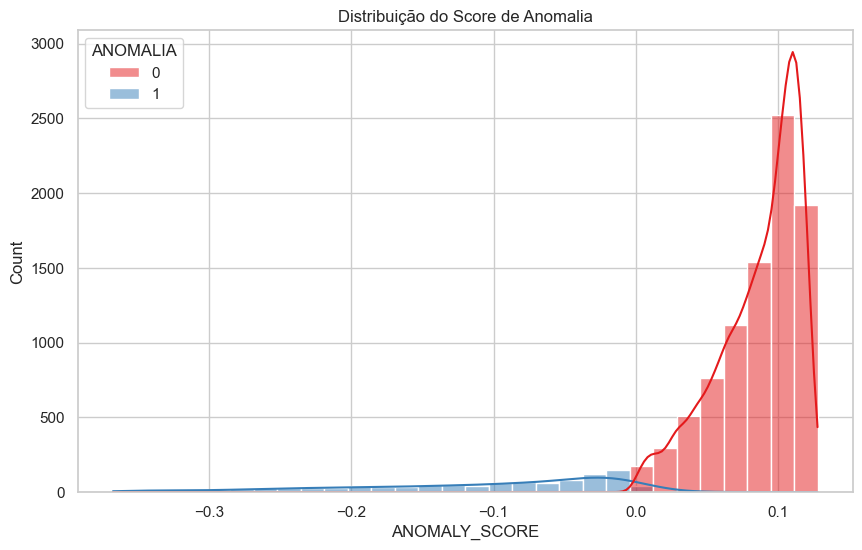

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ANOMALY_SCORE', hue='ANOMALIA', kde=True, bins=30, palette='Set1')
plt.title('Distribuição do Score de Anomalia')
plt.show()

In [16]:
# Exibir as observações identificadas como anômalas
registros_suspeitos = df[df['ANOMALIA'] == 1].sort_values('ANOMALY_SCORE')
print(f"Exportados {len(registros_suspeitos)} registros suspeitos com todas as colunas.")
print(f"Proporção: {len(registros_suspeitos)/len(df):.2%} dos registros foram marcados como suspeitos")
registros_suspeitos.to_csv('registros_suspeitos_completos.csv', index=False, encoding='utf-8-sig')
df[df['ANOMALIA'] == 1].sort_values('ANOMALY_SCORE').head(10)

Exportados 982 registros suspeitos com todas as colunas.
Proporção: 10.00% dos registros foram marcados como suspeitos


,CD_DIST,NM_DIST,M >= 60 ANOS,F >= 60 ANOS,OBITOS TOTAIS (M+F),PCT_DOMICILIOS_COM_OBITO,2019 (M+F >= 60 anos),2020 (M+F >= 60 anos),2021 (M+F >= 60 anos),2022 (M+F >= 60 anos),AREA_KM2,POP_TOTAL,DENSIDADE_DEMOGRAFICA,PCT_IDOSOS,OBITOS_PER_CAPITA,ANOMALY_SCORE,ANOMALIA
1455,230440005,Fortaleza,10559.0,12781.0,44333.0,5.371011,2181.0,3771.0,5325.0,2128.0,312.352783,2428708.0,7775.528605,0.961005,0.018254,-0.367495,1
6330,330455705,Rio de Janeiro,36605.0,42437.0,138974.0,5.938764,8846.0,12672.0,18775.0,5489.0,1200.329509,6211223.0,5174.598269,1.272567,0.022375,-0.363921,1
192,130260305,Manaus,7757.0,7462.0,36492.0,5.970140,1306.0,2636.0,4133.0,800.0,11401.001701,2063689.0,181.009446,0.737466,0.017683,-0.360793,1
2830,261160605,Recife,7570.0,10467.0,32937.0,6.219638,1912.0,3058.0,4320.0,1416.0,218.842956,1488920.0,6803.600292,1.211415,0.022121,-0.359466,1
10491,520870705,Goiânia,6587.0,5705.0,24863.0,4.704147,1044.0,1828.0,2937.0,921.0,637.668448,1435651.0,2251.406675,0.856197,0.017318,-0.356354,1
4167,310620005,Belo Horizonte,6669.0,7585.0,24848.0,4.896344,1343.0,1661.0,2953.0,1115.0,185.307105,1380747.0,7451.128227,1.032340,0.017996,-0.355986,1
3852,292740805,Salvador,8554.0,11270.0,43903.0,4.798035,2128.0,2650.0,3971.0,1448.0,693.442055,2417678.0,3486.488860,0.819960,0.018159,-0.355617,1
10697,530010805,Brasília,7844.0,7633.0,37007.0,4.080967,1103.0,1827.0,3153.0,911.0,5760.782505,2817381.0,489.062206,0.549340,0.013135,-0.355248,1
7639,410690205,Curitiba,8296.0,8007.0,30668.0,4.697518,1412.0,2080.0,4075.0,1318.0,434.892097,1773718.0,4078.524334,0.919143,0.017290,-0.351940,1
2164,240810205,Natal,4103.0,4707.0,15821.0,5.941864,1166.0,1430.0,2026.0,749.0,167.401324,751300.0,4488.017069,1.172634,0.021058,-0.351781,1
